In [1]:
import sys
sys.path.append("..")

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, KeyedVectors

from src.seeds import Seeds
from src.dataset import Dataset

### Loading tokens
As always, we load the Illinois Appellate Court tokens.

In [2]:
tokens = [e["tokens"] for e in Dataset().load_dataset(year=None, fields={"tokens"}, 
                                                      courts={"Illinois Appellate Court"})]

print("Total documents:", len(tokens))

Total documents: 123915


### Training a Word2Vec model and saving
We now train a Word2Vec gensim model, filtering out words that appear less than five times, with four workers.
The model is then saved to disk and reloaded.

In [3]:
model = Word2Vec(tokens, min_count=5, workers=4)

In [4]:
vectors_path = "../data/models/vectors/Illinois_appellate_vectors.kv"

In [5]:
model.wv.save(vectors_path)

In [6]:
word_vectors = KeyedVectors.load(vectors_path)

### Finding similar words
The model can find similar words to a given one by considering similar vectors.

In [7]:
for word in ["cocaine", "rape", "gun"]:
    try:
        sim = word_vectors.most_similar(word, topn=5)
        print(word, ":\n\t- " + "\n\t- ".join([f"{e[0]} ({round(e[1], 2)})" for e in sim]), "\n")
    except:
        print(word, ": not present in vocab\n")

cocaine :
	- heroin (0.95)
	- marijuana (0.89)
	- lsd (0.84)
	- narcotic (0.83)
	- cannabis (0.82) 

rape :
	- kidnap (0.74)
	- murder (0.7)
	- assault (0.69)
	- kidnapper (0.69)
	- prosecutrix (0.69) 

gun :
	- pistol (0.92)
	- handgun (0.89)
	- shotgun (0.88)
	- rifle (0.87)
	- revolver (0.84) 



### 2d visualization of interesting words
Reducing dimensionality to two makes possible to visualize datapoints, the original seeds are used, so a small set of narcotics, weapons and investigation terms, otherwise the plot would be too convoluted.

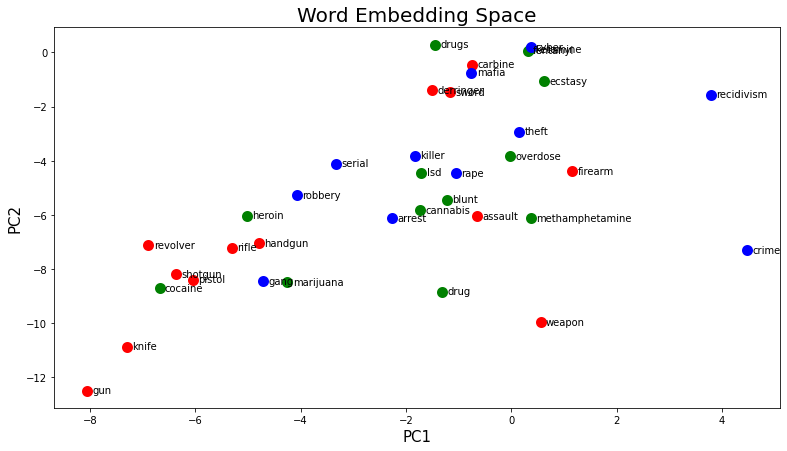

In [8]:
pca = PCA(n_components=2)
pca.fit(word_vectors.vectors)

interesting = [list(e) for e in Seeds().get_starting_seeds()]

plt.figure(figsize=(13,7))

colors = ["green", "red", "blue"]

for i, l in enumerate(interesting):
    vectors = []
    for w in l.copy():
        try:
            vectors.append(word_vectors[w])
        except:
            l.remove(w)
            
    vectors = np.array(vectors)
    r_vectors = pca.transform(vectors)
    
    plt.scatter(r_vectors[:,0],r_vectors[:,1],linewidths=5,color=colors[i])
    
    for i, word in enumerate(l):
        plt.annotate(word,xy=(r_vectors[i,0]+0.1,r_vectors[i,1]-0.1))
        
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)

plt.title("Word Embedding Space",size=20)

plt.show()

### Training smaller models for each epoch

The model is now trained on the different epochs the goal is to find differences between vectors in different years.

The idea is to find different correlations among the temporal axis.

In [2]:
for year in [1760, 1800, 1820, 1840, 1860, 1900, 
             1920, 1940, 1960, 1980, 2000]:
    
    tokens = [e["tokens"] for e in Dataset().load_dataset(year=year, fields={"tokens"})]
    print(f"Processing {len(tokens)} docs, year: {year}-{year+19}")
    
    model = Word2Vec(tokens, min_count=5, workers=4)
    model.wv.save(f"../data/models/vectors/{year}_vectors.kv")

Processing 1 docs, year: 1760-1779
Processing 5 docs, year: 1800-1819
Processing 440 docs, year: 1820-1839
Processing 2657 docs, year: 1840-1859
Processing 9255 docs, year: 1860-1879
Processing 28932 docs, year: 1900-1919
Processing 26954 docs, year: 1920-1939
Processing 14668 docs, year: 1940-1959
Processing 33683 docs, year: 1960-1979
Processing 35641 docs, year: 1980-1999
Processing 11262 docs, year: 2000-2019


### Finding differences in word vectors among the temporal axis

In [16]:
words = ["cocaine", "rape", "gun"]
vectors = defaultdict(lambda:[])

for year in [1760, 1800, 1820, 1840, 1860, 1900, 
            1920, 1940, 1960, 1980, 2000]:

    vectors_path = f"../data/models/vectors/{year}_vectors.kv"
    word_vectors = KeyedVectors.load(vectors_path)
    for w in words:
        try: 
            vectors[w].append(word_vectors[w])
        except:
            print(f"{w} not found in {year}")

for w in words:
    vectors[w] = np.array(vectors[w])

cocaine not found in 1760
rape not found in 1760
gun not found in 1760
cocaine not found in 1800
rape not found in 1800
gun not found in 1800
cocaine not found in 1820
rape not found in 1820
gun not found in 1820
cocaine not found in 1840
cocaine not found in 1860
cocaine not found in 1920


### Fixed a word, find differences between models pairwise

!! NEED ALIGNMENT: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

In [70]:
v = vectors["gun"]

for s, e in zip(range(len(n)), range(1, len(n))):
    print(np.linalg.norm(v[s]-v[e]))

2.9733057
11.571817
19.796701
22.902622
25.259192
32.846302
31.66255


In [81]:
models = [(year, KeyedVectors.load(f"../data/models/vectors/{year}_vectors.kv")) 
          for year in [1760, 1800, 1820, 1840, 1860, 1900, 1920, 1940, 1960, 1980, 2000]]

def find_similar(word, models):
    print(word)
    for y, m in models:
        try:
            print(f"\t{y}: {[e[0] for e in m.most_similar(word, topn=5)]}")
        except:
            pass

In [89]:
words = ["drug", "cannabis", "assault", "gun", "homosexual", "black"]
for w in words:
    find_similar(w, models)
    print()

drug
	1840: ['pair', 'pistol', 'earlville', 'medicine', 'charranell']
	1860: ['dealer', 'retail', 'wholesale', 'grocery', 'meat']
	1900: ['druggist', 'wine', 'cocaine', 'nostrum', 'food']
	1920: ['narcotic', 'confectionery', 'beauty', 'medicine', 'butcher']
	1940: ['narcotic', 'addict', 'addiction', 'opium', 'marijuana']
	1960: ['narcotic', 'cocaine', 'heroin', 'depressant', 'barbiturate']
	1980: ['narcotic', 'heroin', 'cocaine', 'pcp', 'marijuana']
	2000: ['narcotic', 'marijuana', 'heroin', 'cocaine', 'cannabis']

cannabis
	1920: ['sativa', 'corrosive', 'copying', 'matrix', 'carbonate']
	1940: ['sativa', 'resin', 'distillation', 'cosmetic', 'hydrocarbon']
	1960: ['marijuana', 'pcp', 'gram', 'substance', 'cocaine']
	1980: ['marijuana', 'cocaine', 'cannabi', 'heroin', 'lsd']
	2000: ['cocaine', 'heroin', 'marijuana', 'methamphetamine', 'narcotic']

assault
	1820: ['imprisonment', 'fregit', 'rawson', 'indict', 'penal']
	1840: ['battery', 'murder', 'malicious', 'crime', 'felony']
	1860: ['